# Advanced Lane Finding

In this project, I will setup an image processing pipeline including:
1. camera calibration and distortion correction
2. create a combination of methods (color transforms, gradients)
3. perform a perspective transform (transform an image to a birds-eye view)
4. locate the laneline pixels and fit their positions with a polynomial
5. calculate the curvature of the lane and the position of the vehicle 
6. warp back the rectified image to the original image

In [1]:
import numpy as np
import cv2
import glob
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ROOT_PATH = '/home/downloads/carnd-p4-advanced-lane-lines'
CAMERA_CAL_PATH = Path(ROOT_PATH)/'camera_cal'
TEST_IMG_PATH = Path(ROOT_PATH)/'test_images'

## Camera Calibration and Distortion Correction

In [4]:
def calibrate_camera(img_path, nx=6, ny=9):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    img_size = None
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)

    # arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    for fname in img_path.glob('calibration*.jpg'):
        img = cv2.imread(fname.as_posix())
        if img_size is None:
            img_size = (img.shape[1], img.shape[0])
            print('img_size', img_size)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
        # find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
    
    # calibrate 
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    
    return mtx, dist

In [5]:
mtx, dist = calibrate_camera(CAMERA_CAL_PATH, nx=6, ny=9)

img_size (1280, 720)


In [484]:
def undist_img(img, mtx, dist):
    img_size = (img.shape[1], img.shape[0])
    
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

In [6]:
def plot_undist(img_path, mtx, dist):
    img = cv2.imread(img_path)
    img_size = (img.shape[1], img.shape[0])

    # Do camera calibration given object points and image points
    #ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    #cv2.imwrite('calibration_wide/test_undist.jpg',dst)

    # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
    # dist_pickle = {}
    # dist_pickle["mtx"] = mtx
    # dist_pickle["dist"] = dist
    # pickle.dump( dist_pickle, open( "calibration_wide/wide_dist_pickle.p", "wb" ) )
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
    # Visualize undistortion
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.imshow(img_rgb)
    ax1.set_title('Original Image', fontsize=20)
    ax2.imshow(dst)
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()

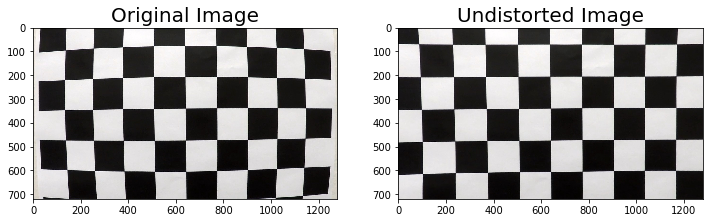

In [7]:
plot_undist((CAMERA_CAL_PATH/'calibration1.jpg').as_posix(), mtx, dist)

Applying undistortion on all test images

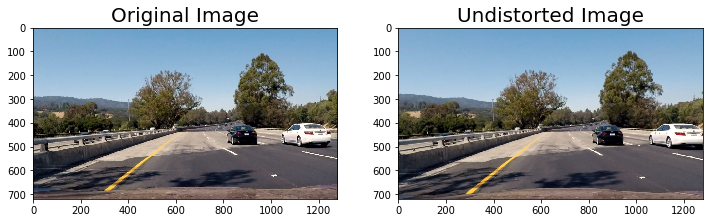

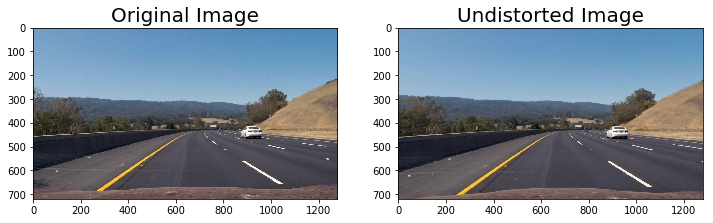

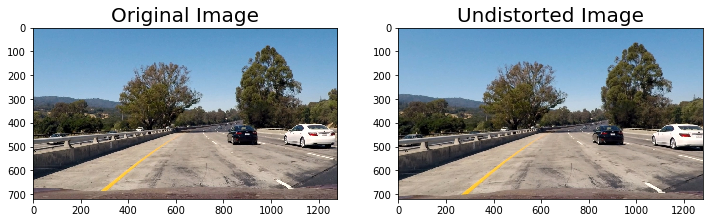

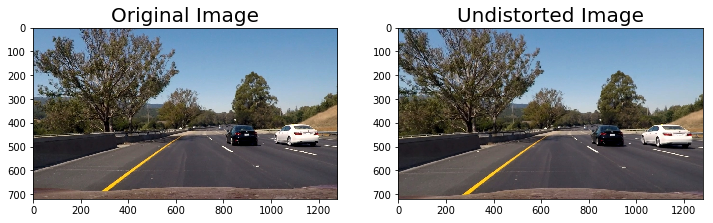

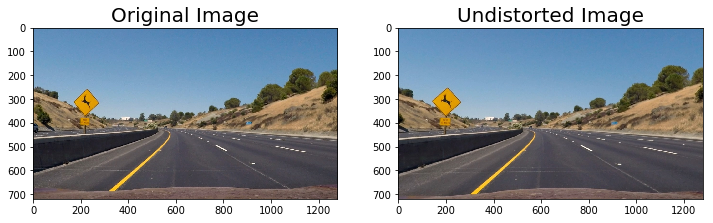

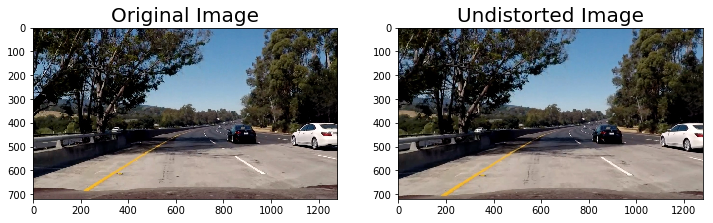

In [8]:
for img_path in TEST_IMG_PATH.glob('test*.jpg'):
    plot_undist(img_path.as_posix(), mtx, dist)

## Image Gradients and Color

### Image Gradients

Take one test image for a quick check

In [965]:
#test_image_path = list(TEST_IMG_PATH.glob('*.jpg'))[0].as_posix()
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg'
test_image_rgb = plt.imread(test_image_path)

In [966]:
def plot_test_image(img_rgb, img_bin, image_names=['Original Image', 'Thresholded Gradient']):
    # Plot the result 
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) 
    f.tight_layout() 
    ax1.imshow(img_rgb) 
    ax1.set_title(image_names[0], fontsize=20) 
    ax2.imshow(img_bin, cmap='gray') 
    ax2.set_title(image_names[1], fontsize=20) 
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    plt.show()

Sobel operator

In [967]:
def abs_sobel_thresh(img_path, orient='x', sobel_kernel=3, thresh=(20, 100)):
    thresh_min, thresh_max = thresh
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 

    if orient == 'x': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    elif orient == 'y': 
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 

    abs_sobel = np.absolute(sobel) 
    scaled_sobel = np.uint8(255*abs_sobel / np.max(abs_sobel)) 
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1 
    return binary_output

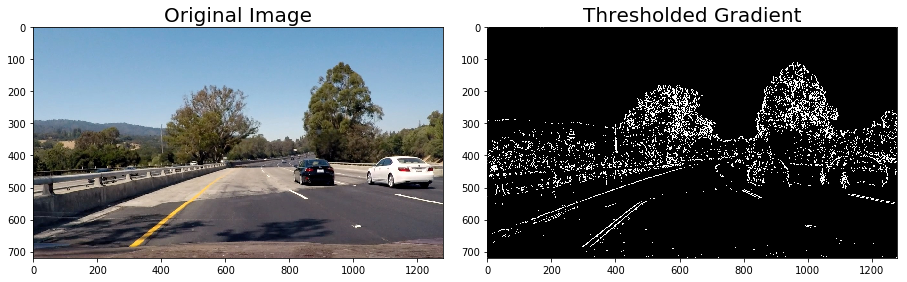

In [968]:
grad_binary = abs_sobel_thresh(test_image_path, orient='x', thresh=(20, 100))
plot_test_image(test_image_rgb, grad_binary)

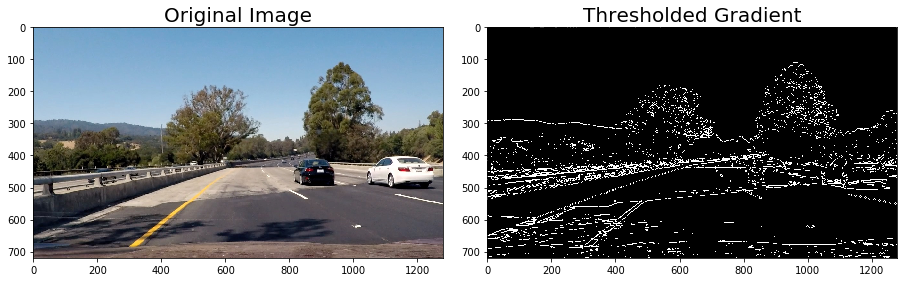

In [969]:
grad_binary = abs_sobel_thresh(test_image_path, orient='y', thresh=(30, 100))
plot_test_image(test_image_rgb, grad_binary)

Gradient magnitude

In [970]:
def mag_thresh(img_path, sobel_kernel=3, mag_thresh=(20, 100)): 
    thresh_min, thresh_max = mag_thresh
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1) 
    gradmag = np.sqrt(sobelx**2 + sobely**2) 
    scaled_sobel = np.uint8(255*gradmag / np.max(gradmag)).astype(np.uint8) 
    binary_output = np.zeros_like(scaled_sobel) 
    binary_output[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1 

    return binary_output 

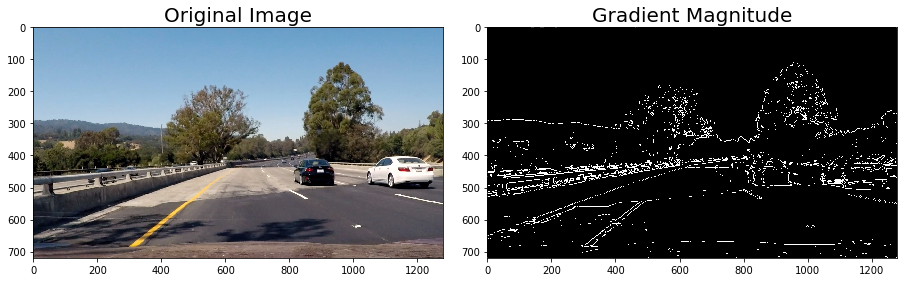

In [971]:
mag_binary = mag_thresh(test_image_path, sobel_kernel=5, mag_thresh=(50, 120))
plot_test_image(test_image_rgb, mag_binary, image_names=['Original Image', 'Gradient Magnitude'])

Gradient Threshold

In [972]:
def dir_threshold(img_path, sobel_kernel=3, thresh=(0, np.pi/2)):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

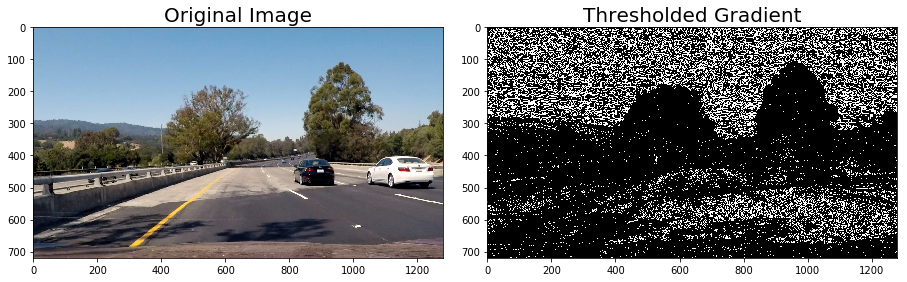

In [973]:
dir_binary = mag_thresh(test_image_path, sobel_kernel=9, mag_thresh=(0.5, 1.1))
plot_test_image(test_image_rgb, dir_binary)

### Image Color

First compare RGB and HLS channels

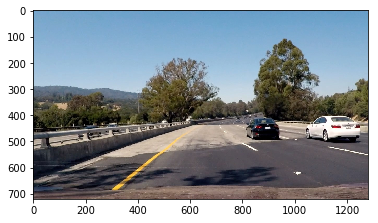

In [1081]:
plt.imshow(test_image_rgb)

In [1081]:
#test_image_path = list(TEST_IMG_PATH.glob('*.jpg'))[0].as_posix()
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg'
test_image_rgb = plt.imread(test_image_path)

plt.imshow(test_image_rgb)

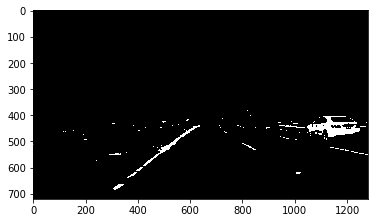

In [1083]:
thresh = (220, 255)
r_bin = np.zeros_like(R)
r_bin[(R>thresh[0])&(R<=thresh[1])] = 1
plt.imshow(r_bin, cmap='gray')

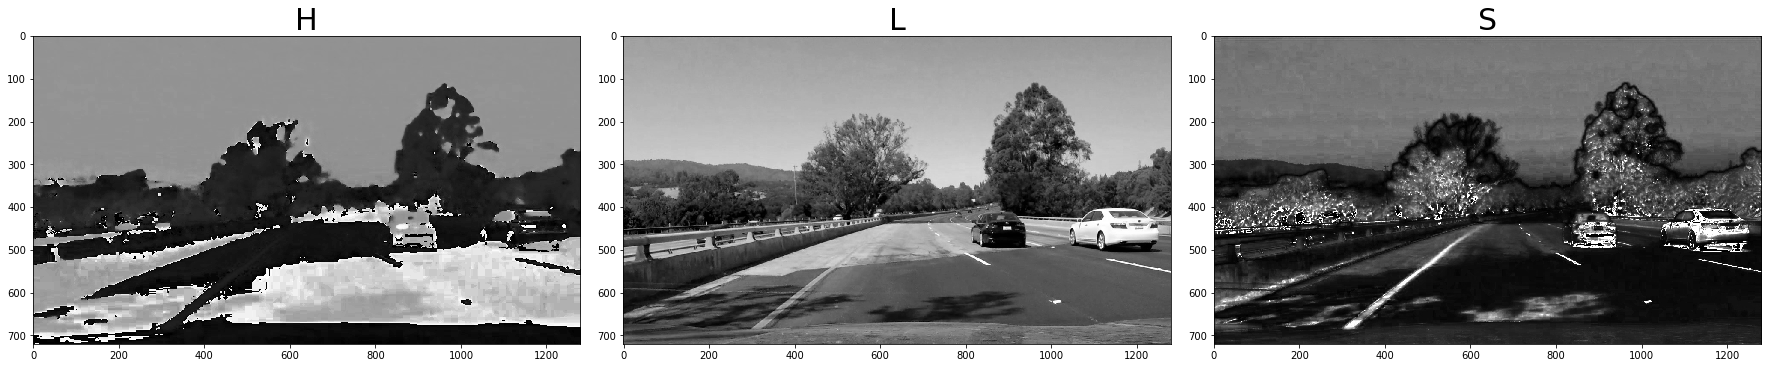

In [1084]:
test_image_hls = cv2.cvtColor(test_image_rgb, cv2.COLOR_RGB2HLS)
H = test_image_hls[:, :, 0]
L = test_image_hls[:, :, 1]
S = test_image_hls[:, :, 2]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9)) 
f.tight_layout() 
ax1.imshow(H, cmap='gray') 
ax1.set_title('H', fontsize=30) 
ax2.imshow(L, cmap='gray') 
ax2.set_title('L', fontsize=30) 
ax3.imshow(S, cmap='gray') 
ax3.set_title('S', fontsize=30) 
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 

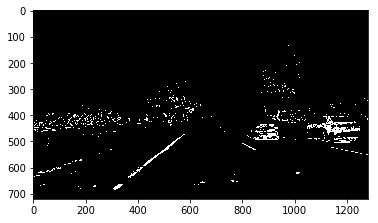

In [1085]:
thresh = (180, 255)
s_bin = np.zeros_like(S)
s_bin[(S>thresh[0])&(S<=thresh[1])] = 1
plt.imshow(s_bin, cmap='gray')

### Select color by yellow and white

In [52]:
def select_rgb_hls_color(rgb, 
                 rgb_w_thresh=([100, 100, 200], [255, 255, 255]),
                 rgb_y_thresh=([225, 180, 0], [255, 255, 170]),
                 hls_y_thresh=([20, 120, 80], [45, 200, 255])):
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    rgb_w_low = np.uint8(rgb_w_thresh[0])
    rgb_w_high = np.uint8(rgb_w_thresh[1])
    
    rgb_y_low = np.uint8(rgb_y_thresh[0])
    rgb_y_high = np.uint8(rgb_y_thresh[1])
    
    hls_y_low = np.uint8(hls_y_thresh[0])
    hls_y_high = np.uint8(hls_y_thresh[1])
    
    rgb_w_bin = cv2.inRange(rgb, rgb_w_low, rgb_w_high)
    rgb_y_bin = cv2.inRange(rgb, rgb_y_low, rgb_y_high)
    hls_y_bin = cv2.inRange(hls, hls_y_low, hls_y_high)
    
    combined_bin = cv2.bitwise_or(rgb_w_bin, rgb_y_bin, hls_y_bin)
    
    return combined_bin

In [279]:
def select_hls_color(rgb, 
                 hls_w_thresh=([10, 190, 0], [255, 255, 255]),
                 hls_y_thresh=([0, 0, 100], [40, 255, 255])):
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    hls_w_low = np.uint8(hls_w_thresh[0])
    hls_w_high = np.uint8(hls_y_thresh[1])
    
    hls_y_low = np.uint8(hls_y_thresh[0])
    hls_y_high = np.uint8(hls_y_thresh[1])
    
    hls_w_bin = cv2.inRange(hls, hls_w_low, hls_w_high)
    hls_y_bin = cv2.inRange(hls, hls_y_low, hls_y_high)
    
    combined_bin = cv2.bitwise_or(hls_w_bin, hls_y_bin)
    
    return combined_bin

In [280]:
#adapted from https://medium.com/@tjosh.owoyemi/finding-lane-lines-with-colour-thresholds-beb542e0d839
def convert_to_bin(img, thresh):
    output_bin = np.zeros_like(img)
    output_bin[(img >= thresh[0]) & (img <= thresh[1])] = 1
    return output_bin

def select_hls_color(rgb, 
                     rgb_w_thresh=([100, 100, 200], [255, 255, 255]),
                     hls_w_thresh=([20, 200, 0], [255, 255, 255]),
                     hls_y_thresh=([10, 0, 100], [40, 255, 255])):
    hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
    bin_thresh = (20, 255)
    
    # thresholding for white in RGB
    rgb_w_low = np.uint8(rgb_w_thresh[0])
    rgb_w_high = np.uint8(rgb_w_thresh[1])
    mask = cv2.inRange(rgb, rgb_w_low, rgb_w_high)
    rgb_w = cv2.bitwise_and(rgb, rgb, mask=mask).astype(np.uint8)
    rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
    rgb_w_bin = convert_to_bin(rgb_w, bin_thresh)
    
    # thresholding for white in HLS
    hls_w_low = np.uint8(hls_w_thresh[0])
    hls_w_high = np.uint8(hls_y_thresh[1])
    mask = cv2.inRange(hls, hls_w_low, hls_w_high)
    hls_w = cv2.bitwise_and(hls, hls, mask=mask).astype(np.uint8)
    hls_w = cv2.cvtColor(hls_w, cv2.COLOR_HLS2RGB)
    hls_w = cv2.cvtColor(hls_w, cv2.COLOR_RGB2GRAY)
    hls_w_bin = convert_to_bin(hls_w, bin_thresh)

    # thresholding for yellow in HLS
    hls_y_low = np.uint8(hls_y_thresh[0])
    hls_y_high = np.uint8(hls_y_thresh[1])
    mask = cv2.inRange(hls, hls_y_low, hls_y_high)
    hls_y = cv2.bitwise_and(hls, hls, mask=mask).astype(np.uint8)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
    hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
    hls_y_bin = convert_to_bin(hls_y, bin_thresh)
    
    combined_bin = np.zeros_like(hls_y)
    combined_bin[(rgb_w_bin==1)|(hls_y_bin==1)|(hls_w_bin==1)] = 1
    
    return combined_bin

In [281]:
color_bin = select_hls_color(test_image_rgb)

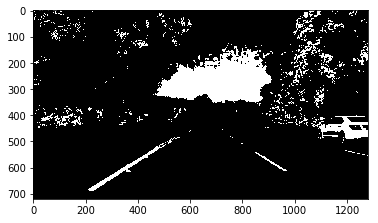

In [264]:
plt.imshow(color_bin, cmap='gray')

### Combining Gradient and Color

In [96]:
def select_image(img_path, sx_thresh=(20, 100), s_thresh=(170, 255)):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

    # Convert to HLS color space and separate the V channel 
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
    #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    l_channel = hls[:,:,1] 
    s_channel = hls[:,:,2] 
    # Sobel x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 

    # Threshold x gradient 
    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1 

    # Threshold color channel 
    s_binary = np.zeros_like(s_channel) 
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 
    # Stack each channel 
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255 
    #color_binary_rgb = cv2.cvtColor(color_binaZZZZry, cv2.COLOR_HLS2RGB)
    return color_binary

In [148]:
def select_image_hls_color(img_path, sx_thresh=(20, 100)):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) 

    # Convert to HLS color space and separate the V channel 
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
    #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    l_channel = hls[:,:,1] 
    
    # Sobel x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 

    # Threshold x gradient 
    sxbinary = np.zeros_like(scaled_sobel) 
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 255 

    # Threshold color channel 
    #s_binary = np.zeros_like(s_channel) 
    #s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1 
    s_binary = select_hls_color(img)
    # Stack each channel 
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary))
    #color_binary_rgb = cv2.cvtColor(color_binaZZZZry, cv2.COLOR_HLS2RGB)
    return color_binary

In [149]:
def combine_selection(color_bin):
    combined_bin = np.zeros_like(color_bin[:, :, 0])
    combined_bin[(color_bin[:,:,1]/255==1)|(color_bin[:,:,2]/255==1)] = 1
    
    return combined_bin

In [150]:
def plot_binary_images(color_bin):
    combined_bin = np.zeros_like(color_bin[:, :, 0])
    combined_bin[(color_bin[:,:,1]/255==1)|(color_bin[:,:,2]/255==1)] = 1

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5)) 
    f.tight_layout() 
    ax1.imshow(color_bin) 
    ax1.set_title('Stacked thresholds', fontsize=20) 
    ax2.imshow(combined_bin, cmap='gray') 
    ax2.set_title('Combined S channel and gradient thresholds', fontsize=20) 
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.) 
    plt.show()

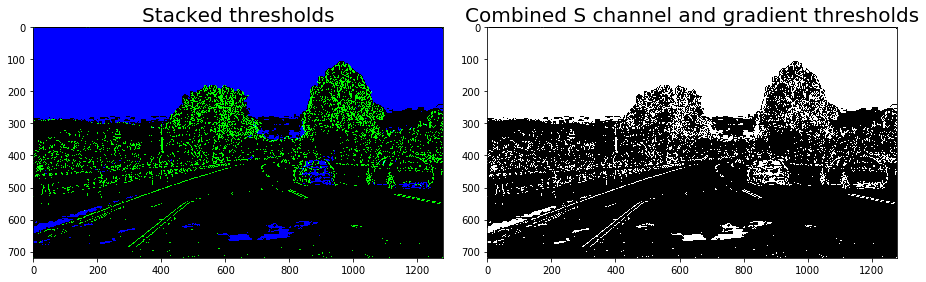

In [153]:
#color_bin = select_image(test_image_path, sx_thresh=(20, 100), s_thresh=(220, 255))
color_bin = select_image_hls_color(test_image_path, sx_thresh=(20, 100))
plot_binary_images(color_bin)

### Perspective Transform for the straight lane lines

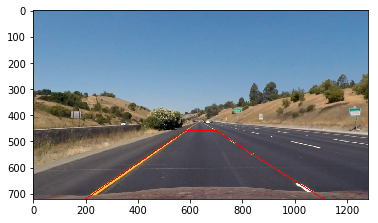

In [1281]:
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines1.jpg'
test_image_rgb = plt.imread(test_image_path)
undist = undist_img(test_image_rgb, mtx, dist)

# choose the polygon region to conduct perspetive transform
src = np.float32([[200, 720], [580, 460], [700, 460], [1110, 720]])
dst = np.float32([[300, 720], [300, 200], [900, 200], [900, 720]])
cv2.polylines(undist, [src.astype(np.int32)], 1, (255,0,0), 2);
plt.imshow(undist)

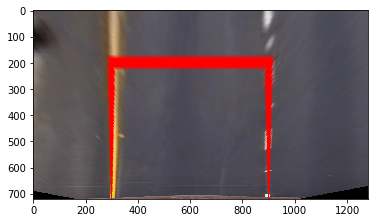

In [1282]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, combined_bin_undist.shape[::-1])

plt.imshow(warped)

Perspective Transform for curved lines

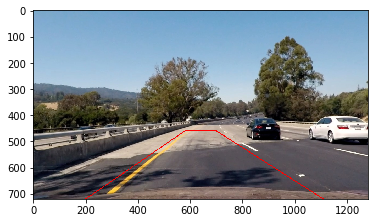

In [1283]:
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg'
test_image_rgb = plt.imread(test_image_path)
undist = undist_img(test_image_rgb, mtx, dist)

# choose the polygon region to conduct perspetive transform
src = np.float32([[200, 720], [580, 460], [700, 460], [1110, 720]])
dst = np.float32([[300, 720], [300, 200], [900, 200], [900, 720]])
cv2.polylines(undist, [src.astype(np.int32)], 1, (255,0,0), 2);
plt.imshow(undist)

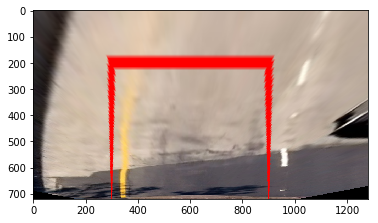

In [1284]:
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(undist, M, combined_bin_undist.shape[::-1])

plt.imshow(warped)

### Perspective Transform

(720, 1280)

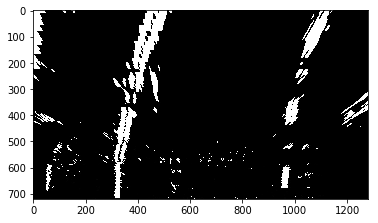

In [1285]:
binary_warped = plt.imread((Path(ROOT_PATH)/'examples/warped_example.png').as_posix())
#test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test3.jpg'
#binary_warped = plt.imread(test_image_path)
binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_RGB2GRAY)
plt.imshow(binary_warped, cmap='gray')

binary_warped.shape

### Locate the lane lines and fit a polynomial

In [1169]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin  # Update this
        win_xleft_high = leftx_current + margin  # Update this
        win_xright_low = rightx_current - margin  # Update this
        win_xright_high = rightx_current + margin  # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & 
                          (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) &
                          (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) &
                           (nonzeroy < win_y_high) & 
                           (nonzerox >= win_xright_low) &
                           (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

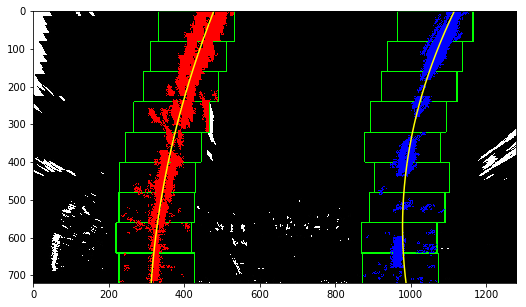

In [1170]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    return left_fitx, right_fitx, ploty


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)
    img_shape = binary_warped.shape

    ## Fit a second order polynomial to each using `np.polyfit`
    left_fitx, right_fitx, ploty = fit_poly(img_shape, leftx, lefty, rightx, righty)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    result = {
        'img': out_img,
        'left_fitx': left_fitx,
        'right_fitx': right_fitx,
        'left_fit': left_fit,
        'right_fit': right_fit,
        'ploty': ploty
    }
    
    return result

def visualize_result(img, left_fitx, right_fitx, ploty):
    # Plots the left and right polynomials on the lane lines
    fig, ax = plt.subplots(1, 1, figsize=(12, 5))
    ax.plot(left_fitx, ploty, color='yellow')
    ax.plot(right_fitx, ploty, color='yellow')
    ax.imshow(img.astype(int))

result = fit_polynomial(binary_warped)
visualize_result(result['img'], result['left_fitx'], result['right_fitx'], result['ploty'])

### Find the lines: search from prior

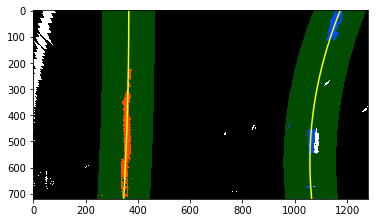

In [1210]:
import pdb
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx =  right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                right_fit[1]*nonzeroy + right_fit[2] + margin)))

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(warped)

# View your output
plt.imshow(result)

### Measuring Curvature

In [1172]:
ploty = result['ploty']
left_fit = result['left_fit']
right_fit = result['right_fit']
left_fitx = result['left_fitx']
right_fitx = result['right_fitx']

# Define y-value where we want radius of curvature
y_eval = np.max(ploty)

In [1173]:
left_rad = (1+(2*left_fit[0]*y_eval+left_fit[1]**2)**1.5)/np.absolute(2*left_fit[0])
right_rad = (1+(2*right_fit[0]*y_eval+right_fit[1]**2)**1.5)/np.absolute(2*right_fit[0])

In [1174]:
print(y_eval, left_rad, right_rad)

719.0 3043.025855996039 2126.2850383644522


In [1175]:
ym_per_pix = 30/720. # meters per pixel in y dimension
xm_per_pix = 3.7/720

In [1176]:
left_fit_real = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
right_fit_real = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

In [1177]:
left_rad = (1+(2*left_fit_real[0]*y_eval*ym_per_pix+left_fit_real[1]**2)**1.5)/np.absolute(2*left_fit_real[0])
right_rad = (1+(2*right_fit_real[0]*y_eval+right_fit_real[1]**2)**1.5)/np.absolute(2*right_fit_real[0])

In [1178]:
left_rad, right_rad

(763.6697069842074, 1366.3020458816072)

## Pipeline

The goals / steps of this project are the following:

1. Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
2. Apply a distortion correction to raw images.
3. Use color transforms, gradients, etc., to create a thresholded binary image.
4. Apply a perspective transform to rectify binary image ("birds-eye view").
5. Detect lane pixels and fit to find the lane boundary.
6. Determine the curvature of the lane and vehicle position with respect to center.
7. Warp the detected lane boundaries back onto the original image.
7. Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [132]:
class LaneFindingPipeline():
    def __init__(self, 
                 root_path, 
                 camera_cal_path, 
                 sx_thresh=(20, 100),
                 s_thresh=(170, 255),
                 nwindows = 9,
                 margin=100,
                 minpix=50,
                 ym_per_pix=30/720., 
                 xm_per_pix=3.7/720):
        self.root_path = root_path
        self.camera_cal_path = camera_cal_path
        self.mtx, self.dist = self._calibrate_camera(camera_cal_path)
        self.sx_thresh = sx_thresh # threshold on the x axis
        self.s_thresh = s_thresh # threshold on S channel (HLS)
        
        # hyperparameters for polinomial fit
        self.nwindows = nwindows
        self.margin= margin
        self.minpix = minpix
        
        # meters per pixel in x and y dimension
        self.ym_per_pix = ym_per_pix
        self.xm_per_pix = xm_per_pix
        
        # define perpective transform and inverse transform
        src = np.float32([[200, 720], [580, 460], [700, 460], [1110, 720]])
        dst = np.float32([[300, 720], [300, 200], [900, 200], [900, 720]])
        
        self.M = cv2.getPerspectiveTransform(src, dst)
        self.Minv = cv2.getPerspectiveTransform(dst, src)
        
        
    def _calibrate_camera(self, img_path, nx=6, ny=9):
        img_size = None
        objp = np.zeros((nx*ny,3), np.float32)
        objp[:,:2] = np.mgrid[0:ny, 0:nx].T.reshape(-1,2)

        # arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.

        for fname in img_path.glob('calibration*.jpg'):
            img = cv2.imread(fname.as_posix())
            if img_size is None:
                img_size = (img.shape[1], img.shape[0])
                print('img_size', img_size)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (ny, nx), None)

            if ret == True:
                objpoints.append(objp)
                imgpoints.append(corners)

        # calibrate 
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

        return mtx, dist

    def undist_img(self, img):
        img_size = (img.shape[1], img.shape[0])
        undist = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        
        return undist
    
    def select_image(self, img):
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
        #rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        l_channel = hls[:,:,1] 
        s_channel = hls[:,:,2] 
        # Sobel x 
        sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x 
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal 
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx)) 

        # Threshold x gradient 
        sxbinary = np.zeros_like(scaled_sobel) 
        sxbinary[(scaled_sobel >= self.sx_thresh[0]) & (scaled_sobel <= self.sx_thresh[1])] = 1 

        # Threshold color channel 
        s_binary = np.zeros_like(s_channel) 
        s_binary[(s_channel >= self.s_thresh[0]) & (s_channel <= self.s_thresh[1])] = 1 
        # Stack each channel 
        color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255 
        #color_binary_rgb = cv2.cvtColor(color_binary, cv2.COLOR_HLS2RGB)
        return color_binary
    
    #adapted from https://medium.com/@tjosh.owoyemi/finding-lane-lines-with-colour-thresholds-beb542e0d839
    def convert_to_bin(self, img, thresh):
        output_bin = np.zeros_like(img)
        output_bin[(img >= thresh[0]) & (img <= thresh[1])] = 1
        return output_bin

    def select_hls_color(self, 
                         rgb, 
                         rgb_w_thresh=([100, 100, 200], [255, 255, 255]),
                         hls_w_thresh=([20, 200, 0], [255, 255, 255]),
                         hls_y_thresh=([10, 0, 100], [40, 255, 255])):
        hls = cv2.cvtColor(rgb, cv2.COLOR_RGB2HLS)
        bin_thresh = (20, 255)

        # thresholding for white in RGB
        rgb_w_low = np.uint8(rgb_w_thresh[0])
        rgb_w_high = np.uint8(rgb_w_thresh[1])
        mask = cv2.inRange(rgb, rgb_w_low, rgb_w_high)
        rgb_w = cv2.bitwise_and(rgb, rgb, mask=mask).astype(np.uint8)
        rgb_w = cv2.cvtColor(rgb_w, cv2.COLOR_RGB2GRAY)
        rgb_w_bin = self.convert_to_bin(rgb_w, bin_thresh)

        # thresholding for white in HLS
        hls_w_low = np.uint8(hls_w_thresh[0])
        hls_w_high = np.uint8(hls_y_thresh[1])
        mask = cv2.inRange(hls, hls_w_low, hls_w_high)
        hls_w = cv2.bitwise_and(hls, hls, mask=mask).astype(np.uint8)
        hls_w = cv2.cvtColor(hls_w, cv2.COLOR_HLS2RGB)
        hls_w = cv2.cvtColor(hls_w, cv2.COLOR_RGB2GRAY)
        hls_w_bin = self.convert_to_bin(hls_w, bin_thresh)

        # thresholding for yellow in HLS
        hls_y_low = np.uint8(hls_y_thresh[0])
        hls_y_high = np.uint8(hls_y_thresh[1])
        mask = cv2.inRange(hls, hls_y_low, hls_y_high)
        hls_y = cv2.bitwise_and(hls, hls, mask=mask).astype(np.uint8)
        hls_y = cv2.cvtColor(hls_y, cv2.COLOR_HLS2RGB)
        hls_y = cv2.cvtColor(hls_y, cv2.COLOR_RGB2GRAY)
        hls_y_bin = self.convert_to_bin(hls_y, bin_thresh)

        combined_bin = np.zeros_like(hls_y)
        combined_bin[(rgb_w_bin==1)|(hls_y_bin==1)|(hls_w_bin==1)] = 1

        return combined_bin

    def combine_selection(self, color_bin):
        combined_bin = np.zeros_like(color_bin[:, :, 0])
        combined_bin[(color_bin[:,:,1]/255==1)|(color_bin[:,:,2]/255==1)] = 1

        return combined_bin
    
    def transform_perspective(self, img):
        warped = cv2.warpPerspective(img, self.M, img.shape[::-1])
        
        return warped
    
    def thresh_transform_perspective(self, img):
        undist = self.undist_img(img)
        #colored_bin = self.select_image(undist)
        #combined_bin = self.combine_selection(colored_bin)  
        colored_bin = self.select_hls_color(undist)
        warped = self.transform_perspective(colored_bin)
        
        return warped
    
    def calculate_hist(self, binary_warped):
        histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
        
        return histogram
    
    def find_lane_pixels(self, binary_warped):
        # Take a histogram of the bottom half of the image
        histogram = self.calculate_hist(binary_warped)
        # Create an output image to draw on and visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]//2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # HYPERPARAMETERS
        # Choose the number of sliding windows
        nwindows = self.nwindows
        # Set the width of the windows +/- margin
        margin = self.margin
        # Set minimum number of pixels found to recenter window
        minpix = self.minpix

        # Set height of windows - based on nwindows above and image shape
        window_height = np.int(binary_warped.shape[0]//self.nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated later for each window in nwindows
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            ### TO-DO: Find the four below boundaries of the window ###
            win_xleft_low = leftx_current - margin  # Update this
            win_xleft_high = leftx_current + margin  # Update this
            win_xright_low = rightx_current - margin  # Update this
            win_xright_high = rightx_current + margin  # Update this

            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low), (win_xright_high,win_y_high), (0,255,0), 2) 

            ### TO-DO: Identify the nonzero pixels in x and y within the window ###
            good_left_inds = ((nonzeroy >= win_y_low) & 
                              (nonzeroy < win_y_high) &
                              (nonzerox >= win_xleft_low) &
                              (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) &
                               (nonzeroy < win_y_high) & 
                               (nonzerox >= win_xright_low) &
                               (nonzerox < win_xright_high)).nonzero()[0]

            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)

            ### TO-DO: If you found > minpix pixels, recenter next window ###
            ### (`right` or `leftx_current`) on their mean position ###
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices (previously was a list of lists of pixels)
        try:
            left_lane_inds = np.concatenate(left_lane_inds)
            right_lane_inds = np.concatenate(right_lane_inds)
        except ValueError:
            # Avoids an error if the above is not implemented fully
            pass

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]

        return leftx, lefty, rightx, righty, out_img
    
    def fit_poly(self, img_shape, leftx, lefty, rightx, righty):
        ### Fit a second order polynomial to each with np.polyfit() ###
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        ploty = np.linspace(0, img_shape[0]-1, img_shape[0])

        try:
            left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
            right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        except TypeError:
            # Avoids an error if `left` and `right_fit` are still none or incorrect
            print('The function failed to fit a line!')
            left_fitx = 1*ploty**2 + 1*ploty
            right_fitx = 1*ploty**2 + 1*ploty

        return left_fit, right_fit, left_fitx, right_fitx, ploty


    def fit_polynomial(self, binary_warped):
        # Find our lane pixels first
        leftx, lefty, rightx, righty, out_img = self.find_lane_pixels(binary_warped)
        img_shape = binary_warped.shape

        ## Fit a second order polynomial to each using `np.polyfit`
        left_fit, right_fit, left_fitx, right_fitx, ploty = self.fit_poly(img_shape, leftx, lefty, rightx, righty)

        ## Visualization ##
        # Colors in the left and right lane regions
        out_img[lefty, leftx] = [255, 0, 0]
        out_img[righty, rightx] = [0, 0, 255]

        result = {
            'img': out_img,
            'left_fitx': left_fitx,
            'right_fitx': right_fitx,
            'left_fit': left_fit,
            'right_fit': right_fit,
            'ploty': ploty
        }

        return result

    def visualize_fit_poly(self, img, polyfits):
        left_fitx, right_fitx, ploty = polyfits['left_fitx'], polyfits['right_fitx'], polyfits['ploty']
        # Plots the left and right polynomials on the lane lines
        fig, ax = plt.subplots(1, 1, figsize=(12, 5))
        ax.plot(left_fitx, ploty, color='red')
        ax.plot(right_fitx, ploty, color='red')
        ax.imshow(img.astype(int), cmap='gray')  
        
    def draw_lane_area(self, img, warped, polyfits, undistorted=False):
        if undistorted == False:
            undist = self.undist_img(img)
        else:
            undist = img
        left_fitx = polyfits['left_fitx']
        right_fitx = polyfits['right_fitx']
        ploty = polyfits['ploty']
        
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.Minv, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
        #plt.imshow(result)
        return result
        
    def process_with_pipeline(self, img):
        #print(img.shape)
        warped = self.thresh_transform_perspective(img)
        polyfits = self.fit_polynomial(warped)
        annotated_img = self.draw_lane_area(img, warped, polyfits)
        
        return annotated_img

### Test pipeline on straight lines

In [133]:
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines1.jpg'
test_image_rgb = plt.imread(test_image_path)
lfp = LaneFindingPipeline(ROOT_PATH, CAMERA_CAL_PATH)

img_size (1280, 720)


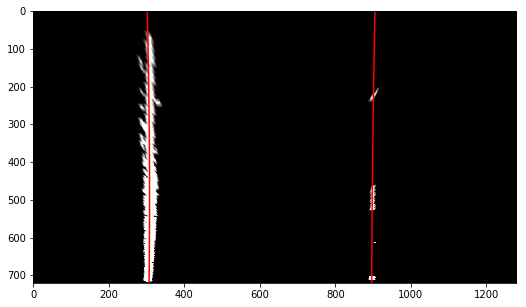

In [135]:
warped = lfp.thresh_transform_perspective(test_image_rgb)
result = lfp.fit_polynomial(warped)
lfp.visualize_fit_poly(warped, result)

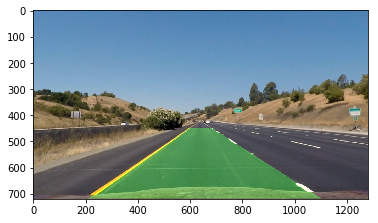

In [136]:
plt.imshow(lfp.process_with_pipeline(test_image_rgb))

### Test pipeline on curved lines (test4 and test5)

In [137]:
test_image_path = '/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg'
test_image_rgb = plt.imread(test_image_path)
lfp = LaneFindingPipeline(ROOT_PATH, CAMERA_CAL_PATH, sx_thresh=(30, 100), s_thresh=(180, 255), nwindows=5)
warped = lfp.thresh_transform_perspective(test_image_rgb)

img_size (1280, 720)


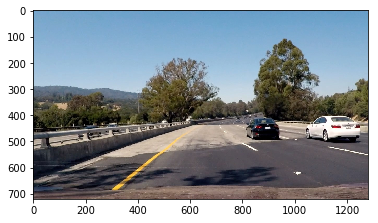

In [138]:
plt.imshow(test_image_rgb)

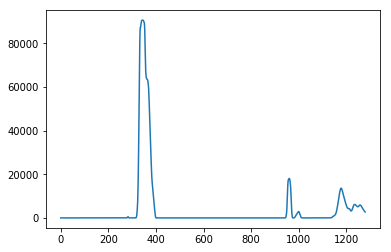

In [139]:
histogram = lfp.calculate_hist(warped)
plt.plot(histogram)

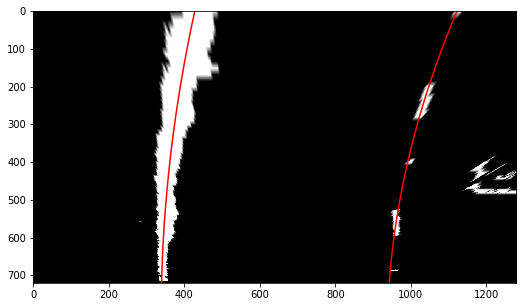

In [140]:
result = lfp.fit_polynomial(warped)
lfp.visualize_fit_poly(warped, result)

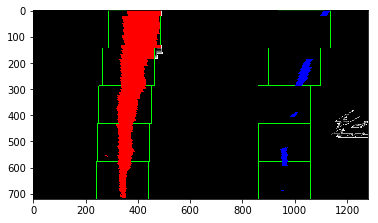

In [141]:
plt.imshow(result['img'])

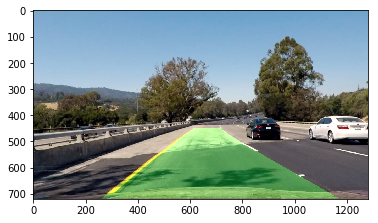

In [142]:
plt.imshow(lfp.draw_lane_area(test_image_rgb, warped, result))

### Applying pipeline on all test images

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test4.jpg


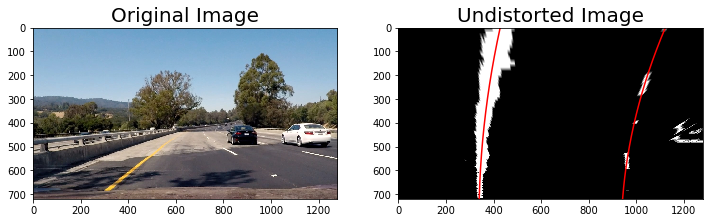

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test3.jpg


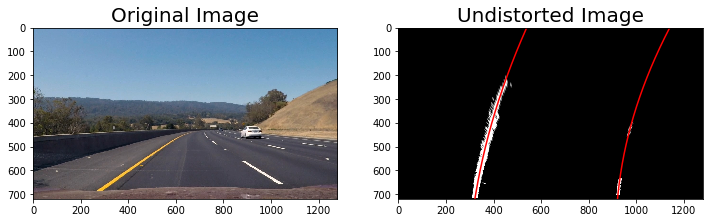

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test1.jpg


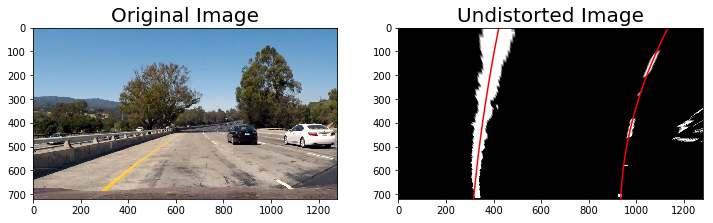

/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines2.jpg


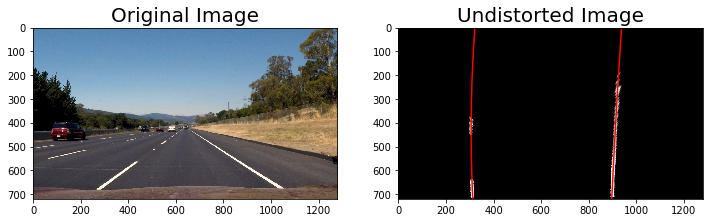

/home/downloads/carnd-p4-advanced-lane-lines/test_images/straight_lines1.jpg


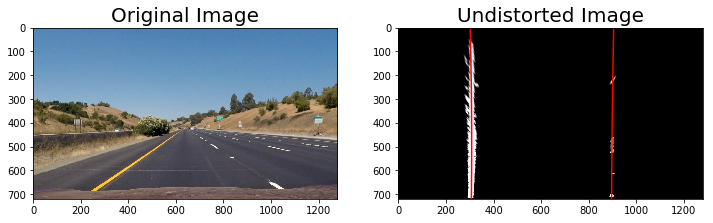

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test6.jpg


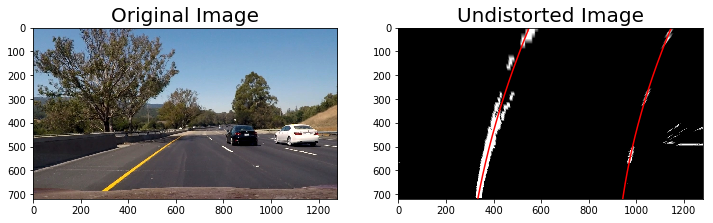

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test2.jpg


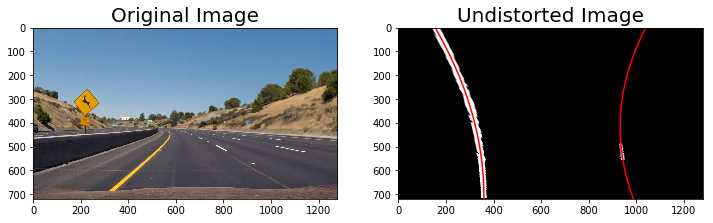

/home/downloads/carnd-p4-advanced-lane-lines/test_images/test5.jpg


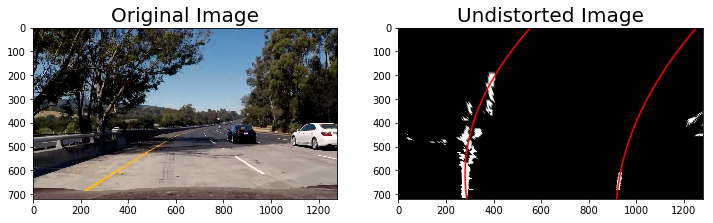

In [143]:
# check all test images
for img_path in TEST_IMG_PATH.glob('*.jpg'):
    print(img_path)
    #plot_undist(img_path.as_posix(), mtx, dist)
    test_image_rgb = plt.imread(img_path)
    warped = lfp.thresh_transform_perspective(test_image_rgb)
    result = lfp.fit_polynomial(warped)
    
    # visualize the original image and warped image with polynomial fit
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
    ax1.imshow(test_image_rgb)
    ax1.set_title('Original Image', fontsize=20)
    left_fitx, right_fitx, ploty = result['left_fitx'], result['right_fitx'], result['ploty']
    ax2.plot(left_fitx, ploty, color='red')
    ax2.plot(right_fitx, ploty, color='red')
    ax2.imshow(warped, cmap='gray') 
    ax2.set_title('Undistorted Image', fontsize=20)
    plt.show()

## Test on videos

In [26]:
# Import everything needed to edit/save/watch video clips# Import 
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
VIDEO_INPUT_PATH = Path(ROOT_PATH)/'test_videos'
VIDEO_OUTPUT_PATH = Path(ROOT_PATH)/'test_videos_result'

In [28]:
lfp = LaneFindingPipeline(ROOT_PATH, CAMERA_CAL_PATH, 
                          sx_thresh=(30, 100), s_thresh=(180, 255), nwindows=5)

img_size (1280, 720)


In [29]:
clip1 = VideoFileClip((VIDEO_INPUT_PATH/'project_video.mp4').as_posix())
white_clip = clip1.fl_image(lfp.process_with_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'project_video_result.mp4').as_posix(), audio=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4


100%|█████████▉| 1260/1261 [01:29<00:00, 14.02it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/project_video_result.mp4 

CPU times: user 3min 44s, sys: 5min 17s, total: 9min 2s
Wall time: 1min 30s


In [30]:
clip2 = VideoFileClip((VIDEO_INPUT_PATH/'challenge_video.mp4').as_posix())
white_clip = clip2.fl_image(lfp.process_with_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'challenge_video_result.mp4').as_posix(), audio=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4


100%|██████████| 485/485 [00:32<00:00, 15.00it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/challenge_video_result.mp4 

CPU times: user 1min 25s, sys: 2min 3s, total: 3min 28s
Wall time: 32.7 s


In [31]:
clip3 = VideoFileClip((VIDEO_INPUT_PATH/'harder_challenge_video.mp4').as_posix())
white_clip = clip3.fl_image(lfp.process_with_pipeline) #NOTE: this function expects color images!!
%time white_clip.write_videofile((VIDEO_OUTPUT_PATH/'harder_challenge_video_result.mp4').as_posix(), audio=False)

[MoviePy] >>>> Building video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/harder_challenge_video_result.mp4
[MoviePy] Writing video /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/harder_challenge_video_result.mp4


100%|█████████▉| 1199/1200 [01:31<00:00, 13.04it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: /home/downloads/carnd-p4-advanced-lane-lines/test_videos_result/harder_challenge_video_result.mp4 

CPU times: user 3min 39s, sys: 4min 52s, total: 8min 32s
Wall time: 1min 32s
